# Text analysis of the [*Libellus de Medicinalibus Indorum Herbis*](https://en.wikipedia.org/wiki/Libellus_de_Medicinalibus_Indorum_Herbis), or the Codex de la Cruz-Badiano (1552)

From the William Gates translation into English (1939), published by the Maya Society ([link](https://en.wikipedia.org/wiki/File:The_De_la_Cruz-Badiano_Aztec_Herbal_of_1552.pdf)).

______

### Import necessary modules

In [85]:
import pandas as pd # for working with dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting

# for NLP analysis
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import nltk
nltk.download('punkt')
warnings.filterwarnings(action='ignore')
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering # for agglomerative clustering

[nltk_data] Downloading package punkt to /Users/chitwoo9/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read in subchapter texts and create a list of file names

In [2]:
data_dir = "./modified_texts/" # set data directory
file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
file_names.remove('.DS_Store') # remove .DS_Store file
file_names.sort() # sort the list of file names
file_names # check list of file names

subchapter_names = [] # get subchapter names without ".txt"
for i in range(len(file_names)):
    subchapter_names.append(file_names[i][:-4])

texts = [] # a list to store text strings
for i in file_names: # for each file
    # read in text, replace \n with space, store in list
    texts.append(Path(data_dir+i).read_text().replace('\n', ' ')) 

### Read in the data to verify presence of Náhuatl words in subchapters

In [3]:
df = pd.read_csv("./verify_subchapter.csv") # read in subchapter data
subchapter = df["subchapter"].str.split(";", expand=True) # split subchapter data
subchapter.fillna(0, inplace=True) # replace None and NaN with 0
nahuatl = df["nahuatl"] # isolate the nahuatl column
official_name = df["official_name"] # isolate the official_name column
ID = df["ID"] # isolate the ID column
type = df["type"] # isolate the type column

### Find names associated with chapters

In [4]:
# store information for search in lists
chapter_list = []
ID_list = []
type_list = []
name_list = []
official_list = []

for i in range(len(subchapter_names)): # for each subchapter

    #######################################################
    ### FIND NÁHUATL NAMES ASSOCIATED WITH EACH CHAPTER ###
    #######################################################

    chapter = subchapter_names[i] # get the current chapter name
    
    if chapter[0]=="0": # remove leading zeros from chapter name
        chapter = chapter[1:]
    
    matches = [] # save matches to chapter
    rows = [] # save rows/index in df to matches
    
    for j in range(len(subchapter)): # for each row 
        for k in range(len(subchapter.columns)): # for each column
    
            if chapter in str(subchapter.iloc[j,k]): # if subchapter found in entry, save to list
                matches.append(subchapter.iloc[j,k])
                rows.append(j)

    plus_one_chapter = "1"+chapter # add "1" to remove unwanted chapters

    remove_inds = [] # save the indices to remove in matches and rows
    for s in range(len(matches)):
        if plus_one_chapter in matches[s]:
            remove_inds.append(s)
    
    remove_inds.sort(reverse=True) # reverse sort indices for removal
    
    for index in remove_inds: # remove indices from matches and rows
        del matches[index]
        del rows[index]
    
    for l in range(len(matches)): # remove leading and trailing zeros from matches
        if matches[l][0] == " ":
            matches[l] = matches[l][1:]
        if matches[l][-1] == " ":
            matches[l] = matches[l][:-1]


    #############################################
    ### FIND MATCHES TO NÁHUATL NAMES IN TEXT ###
    #############################################
    
    nahuatl_names = [] # find nahuatl names for each matched index
    types = [] # find type for each matched index
    IDs = [] # find IDs for each matched index
    official_names = [] # find original names for each matched index
    for m in rows:
        nahuatl_names.append(nahuatl.iloc[m])
        types.append(type.iloc[m])
        IDs.append(ID.iloc[m])
        official_names.append(official_name[m])
    
    nahuatl_names = [x.lower() for x in nahuatl_names] # make all nahuatl names lowercase
    official_names = [x.upper() for x in official_names] # make all official names uppercase
    
    for n in range(len(nahuatl_names)): # split by "; " if multiple names
        if ";" in nahuatl_names[n]:
            nahuatl_names[n] = nahuatl_names[n].split("; ")
    
    for o in range(len(matches)): # find alternate names in matches
        if " " in matches[o]:
            matches[o] = matches[o][:matches[o].rfind(" ")]
        else: # if no alternate, replace with nahuatl name
            matches[o] = nahuatl_names[o]
    
    names_list = [] # combine the names in matches and nahuatl_names together for each entry
    for p in range(len(matches)):
        
        temp_list = []
        if isinstance(matches[p], list):
            for q in matches[p]:
                temp_list.append(q)
        else:
            temp_list.append(matches[p])
    
        if isinstance(nahuatl_names[p], list):
            for q in nahuatl_names[p]:
                temp_list.append(q)
        else:
            temp_list.append(nahuatl_names[p])
    
        names_list.append(temp_list)
    
    unique_names = [] # find only unique names for each entry
    for r in range(len(names_list)):
        unique_names.append(list(set(names_list[r])))

    # store information to lists
    chapter_list.append(chapter)
    ID_list.append(IDs)
    type_list.append(types)
    name_list.append(unique_names)
    official_list.append(official_names)



### Check if names are in the text

In [5]:
present_list = [] # overall present/absent chapter/IDs
absent_list = []

for i in range(len(chapter_list)):

    # get current data for the text
    curr_chapter = chapter_list[i]
    curr_txt = texts[i]
    curr_names = name_list[i]
    curr_IDs = ID_list[i]
    curr_types = type_list[i]
    curr_official = official_list[i]
    
    # for each of the current names
    # determine if present/absent in current text
    for j in range(len(curr_names)):
        present = "No"
        for name in curr_names[j]:
            if name in curr_txt:
                present = "Yes"
                break
        if present == "Yes": # save presence/absence info
            present_list.append([curr_chapter,curr_IDs[j], curr_types[j], curr_official[j], name])
        else:
            absent_list.append([curr_chapter,curr_IDs[j], curr_types[j], curr_official[j], name])

print("Present matches:",len(present_list))
print("Absent matches:",len(absent_list))

Present matches: 525
Absent matches: 0


### Annotate and replace text

In [6]:
present_df = pd.DataFrame(present_list, columns=["chapter","ID","type","official","match"]) # convert matches to dataframe

save_dir = "./annotated_texts/" # set directory to save annotated files to

chapters = present_df["chapter"].unique() # get the unique chapters

annotated_texts = [] # create a list to store annotated chapter texts

for i in range(len(chapters)): # for each subchapter

    curr_chapter = chapters[i] # get the current subchapter
    # mask for current subchapter and remove duplicate rows
    chapter_df = present_df[present_df["chapter"]==curr_chapter].drop_duplicates().reset_index(drop=True) # isolate
    
    if len(curr_chapter)==2: # add zeros if needed to subchapter name
        curr_chapter = "0"+curr_chapter
    
    print("### CHAPTER", curr_chapter, "###")
    
    curr_txt = Path(data_dir+curr_chapter+".txt").read_text().replace('\n', ' ') # read in current subchapter
    curr_txt = curr_txt.replace("  ", " ") # replace double spaces with single spaces
    
    for j in range(len(chapter_df)):
        curr_txt = curr_txt.replace(chapter_df["match"].iloc[j], chapter_df["ID"].iloc[j])
                                    #"["+chapter_df["ID"].iloc[j]+"; "+chapter_df["type"].iloc[j]+"; "+chapter_df["official"].iloc[j]+"]")
    
    print(curr_txt, "\n")
    annotated_texts.append(curr_txt) # save the current text

    with open(save_dir+curr_chapter+".txt", "w") as file: # Open the file in write mode ('w')
        # Write the data to the file
        file.write(curr_txt)


### CHAPTER 01a ###
Curation of the head. The fruit of the ID028 plant, the ID049, the ID150, the precious stones the ID266, ID267, ID268, ID269, bruised up together in frigid water, allay heat in the head, and if in hot water an excess of cold. They are applied three times a day, morning, noon and evening, to be wrapped about the neck and throat over the supporting tendons and throat nerves. For pains in the head let him eat onions in honey, let him not sit in the sun, nor labor, nor enter the baths. 

### CHAPTER 01b ###
Boils. The leaves of the ID215 plant, root of the ID198, ID220 and ID092 plant, well macerated in the yolk of egg without water, will thoroughly cleanse out head boils; they are to be applied daily, morning, noon and evening, in doing which let the head be well covered. But if at any place the head is festered, it is to be washed with urine, and the ointment then used. 

### CHAPTER 01c ###
Scales or mange. A scaly head being diligently washed with heated lye, the ju

### Word2vec

In [7]:
# chapters: a list of unique subchapters
# annotated_texts: a list of annotated texts (replaced with IDs)

unique_IDs = present_df["ID"].unique() # generate unique IDs

corpora = [] # a list of corpora, corresponding to concatenated chapter texts containing each unique ID

for i in range(len(unique_IDs)): # for each unique ID

    curr_ID = unique_IDs[i] # get the current ID
    
    ID_df = present_df[present_df["ID"]==curr_ID] # get all chapters that mention the current ID
    
    ID_chapters = ID_df["chapter"].unique() # get unique chapters that contain the ID
    
    # create a list of chapter texts that mention the current ID
    atext_list = [] # a list of annotated text chapters for the current ID
    for j in range(len(ID_chapters)): # for each of the unique chapters containing the ID
        ind = np.where(chapters == ID_chapters[j])[0][0] # get index for the current chapter
        atext_list.append(annotated_texts[ind]) # get the corresponding annotated text
    
    # create a single concatenated string of the chapter texts that mention the current ID
    s = "" # create a new string
    for k in range(len(atext_list)):
        s += atext_list[k]
        s += " "

    # add the concatenated text to the corpora list
    corpora.append(s)


<Axes: ylabel='Count'>

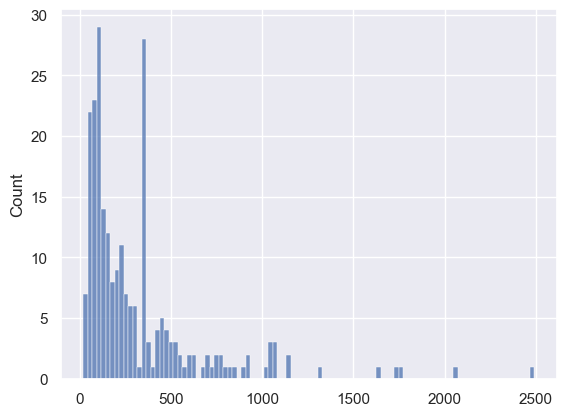

In [87]:
#####
# Create a list of lists of tokenized data for corpora associated with each Náhuatl word
#####

data = [] # a list of lists of tokenized texts

for i in range(len(corpora)):

    curr_txt = corpora[i] # get the current text
    word_tokens = word_tokenize(curr_txt) # tokenize the text
    
    lower_words = [] # a list of lowercase tokens
    for j in range(len(word_tokens)):
        lower_words.append(word_tokens[j].lower())

    data.append(lower_words) # store the lowercase tokenized text

#####
# Look at lengths of each corpus
#####

txt_lens = [] # a list to store the lengths of each text

for i in range(len(data)):
    txt_lens.append(len(data[i]))

max_len = max(txt_lens) # get max corpus length

sns.histplot(txt_lens, bins=100) # look at distribution of lengths

In [12]:
# Create CBOW model
# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
# vector_size (int, optional) – Dimensionality of the word vectors.
# window (int, optional) – Maximum distance between the current and predicted word within a sentence.
# min_count (int, optional) – Ignores all words with total frequency lower than this.
cbow_model = gensim.models.Word2Vec(data, min_count=1,
                                vector_size=100, window=max_len*10, sg=0)

In [17]:
# Access word count
words = list(cbow_model.wv.index_to_key)
print("There are", len(cbow_model.wv), "words") 

# See most frequent words
print("Most frequent words:",words[0:100])

There are 1513 words
Most frequent words: [',', 'the', 'and', 'of', '.', 'in', 'a', 'with', 'is', 'be', 'to', 'water', ';', 'also', 'let', 'this', 'are', 'or', 'which', 'leaves', 'white', 'from', 'for', 'ground', 'then', 'body', 'stones', 'that', 'these', 'you', 'liquor', 'up', 'by', 'root', 'one', 'all', 'on', 'into', 'plants', 'drink', 'him', 'it', 'crushed', 'will', 'red', 'plant', 'some', 'he', '’', 'if', 'as', 'at', 'stone', 's', 'flowers', 'his', 'prepared', 'together', 'blood', 'feet', 'id268', 'out', 'head', 'may', 'juice', 'earth', 'when', 'bark', 'part', 'id028', 'hot', 'take', 'heat', 'tree', 'herb', 'put', 'flower', 'id272', 'an', 'burned', 'made', 'anointed', 'ocelot', 'well', 'potion', 'bush', 'id257', 'gall', 'eyes', 'small', 'heated', 'id266', 'id215', 'trees', 'pearl', 'called', 'roots', 'boiled', 'precious', 'id038']


In [88]:
# create a list of words to analyze with Náhuatl words in most common 100

common_100 = [
'water',
'leaves',
'white',
'ground',
'body',
'stones',
'liquor',
'root',
'plants',
'drink',
'crushed',
'red',
'plant',
'stone',
'flowers',
'blood',
'feet',
'head',
'juice',
'earth',
'bark',
'hot',
'heat',
'tree',
'herb',
'flower',
'burned',
'anointed',
'ocelot',
'potion',
'bush',
'gall',
'eyes',
'heated',
'trees',
'pearl',
'roots',
'boiled',
'precious',
]


In [24]:
#####
# Retrieve the mentioned ID values
#####

# function to determine if a number in a string
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

ids = [] # a list of mentioned ID values
for i in range(len(words)):
    if "id" in words[i]:
        if has_numbers(words[i]):
            if words[i][0:2] == "id":
                if has_numbers(words[i][-1]) == True:
                    ids.append(words[i])

# check ids
print(len(ids))
ids

239


['id268',
 'id028',
 'id272',
 'id257',
 'id266',
 'id215',
 'id038',
 'id056',
 'id291',
 'id172',
 'id068',
 'id292',
 'id160',
 'id208',
 'id054',
 'id017',
 'id041',
 'id018',
 'id288',
 'id287',
 'id286',
 'id085',
 'id293',
 'id094',
 'id024',
 'id103',
 'id042',
 'id150',
 'id200',
 'id298',
 'id278',
 'id001',
 'id060',
 'id222',
 'id045',
 'id037',
 'id099',
 'id113',
 'id058',
 'id295',
 'id281',
 'id240',
 'id209',
 'id104',
 'id247',
 'id254',
 'id221',
 'id220',
 'id158',
 'id290',
 'id289',
 'id023',
 'id294',
 'id030',
 'id021',
 'id051',
 'id047',
 'id181',
 'id006',
 'id279',
 'id301',
 'id062',
 'id105',
 'id128',
 'id304',
 'id263',
 'id214',
 'id234',
 'id303',
 'id296',
 'id299',
 'id297',
 'id007',
 'id109',
 'id302',
 'id198',
 'id241',
 'id180',
 'id155',
 'id070',
 'id190',
 'id310',
 'id196',
 'id131',
 'id307',
 'id306',
 'id074',
 'id213',
 'id305',
 'id226',
 'id069',
 'id277',
 'id072',
 'id204',
 'id148',
 'id134',
 'id217',
 'id147',
 'id107',
 'id149',


In [89]:
#####
# combine words + ids
#####

words_ids = common_100 + ids

words_ids

['water',
 'leaves',
 'white',
 'ground',
 'body',
 'stones',
 'liquor',
 'root',
 'plants',
 'drink',
 'crushed',
 'red',
 'plant',
 'stone',
 'flowers',
 'blood',
 'feet',
 'head',
 'juice',
 'earth',
 'bark',
 'hot',
 'heat',
 'tree',
 'herb',
 'flower',
 'burned',
 'anointed',
 'ocelot',
 'potion',
 'bush',
 'gall',
 'eyes',
 'heated',
 'trees',
 'pearl',
 'roots',
 'boiled',
 'precious',
 'id268',
 'id028',
 'id272',
 'id257',
 'id266',
 'id215',
 'id038',
 'id056',
 'id291',
 'id172',
 'id068',
 'id292',
 'id160',
 'id208',
 'id054',
 'id017',
 'id041',
 'id018',
 'id288',
 'id287',
 'id286',
 'id085',
 'id293',
 'id094',
 'id024',
 'id103',
 'id042',
 'id150',
 'id200',
 'id298',
 'id278',
 'id001',
 'id060',
 'id222',
 'id045',
 'id037',
 'id099',
 'id113',
 'id058',
 'id295',
 'id281',
 'id240',
 'id209',
 'id104',
 'id247',
 'id254',
 'id221',
 'id220',
 'id158',
 'id290',
 'id289',
 'id023',
 'id294',
 'id030',
 'id021',
 'id051',
 'id047',
 'id181',
 'id006',
 'id279',
 'id

In [28]:
#####
# Create a cosine similarity matrix between words and IDs
#####

cosine_sim = np.zeros((len(words_ids), len(words_ids)))

for i in range(len(words_ids)):
    #print(ids[i])
    for j in range(len(words_ids)):
        cosine_sim[i,j] = cbow_model.wv.similarity(words_ids[i].lower(), words_ids[j].lower())

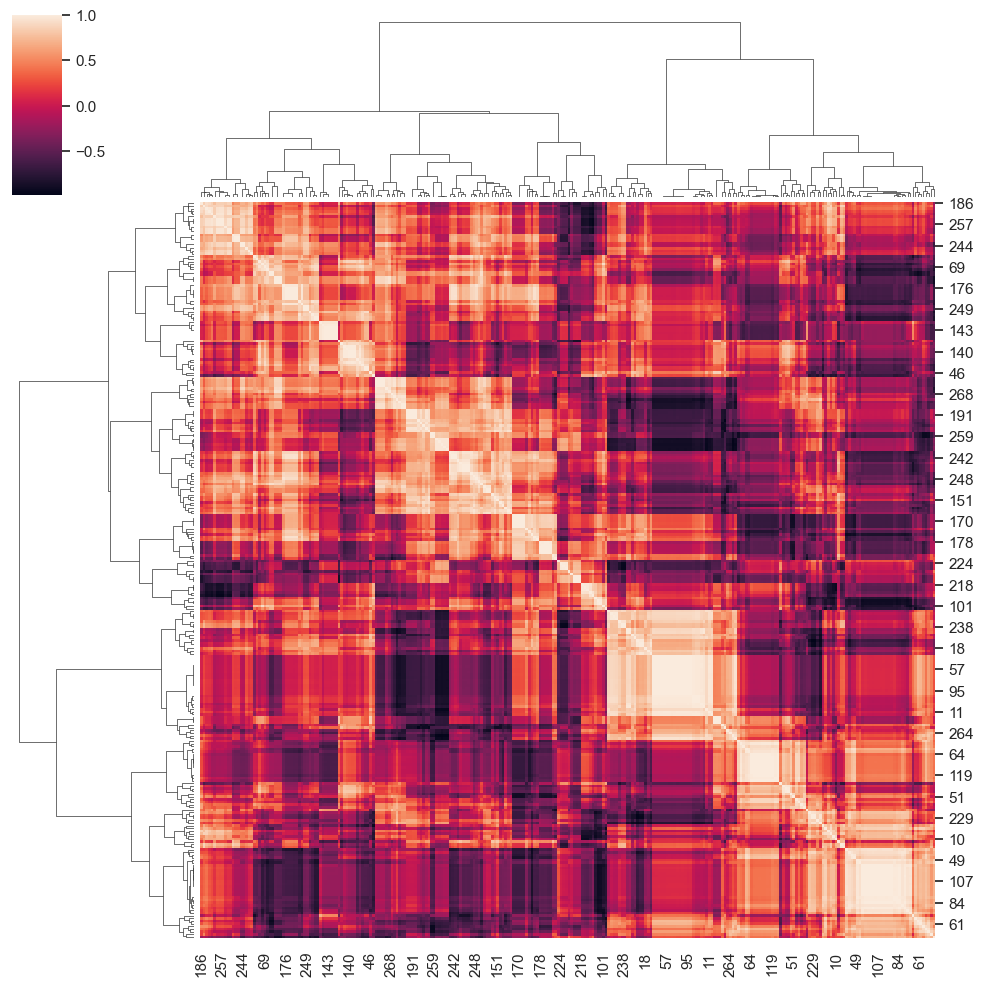

In [90]:
#####
# Get labels of dendrogram
#####

# select clustering method
m = "ward" # 'single', 'average', 'complete', 'ward'

# produce clustering to get labels
g = sns.clustermap(cosine_sim, method=m)

# get the indices of the rows
row_labels = g.dendrogram_row.reordered_ind

#####
# Get IDs, names, types and calculate colors of labels
#####

cluster_ID = [] # store cluster ID
cluster_name = [] # store cluster name
cluster_type = [] # store cluster type
cluster_col = [] # store cluster color

for i in range(len(row_labels)):

    curr_word = words_ids[int(row_labels[i])]

    if curr_word[0:2]=="id":
    
        curr_ID = curr_word.upper()
        cluster_ID.append(curr_ID)
        cluster_name.append(present_df["official"][present_df["ID"]==curr_ID].iloc[0])
        curr_type = present_df["type"][present_df["ID"]==curr_ID].iloc[0]
        cluster_type.append(curr_type)
        if curr_type == "plant":
            cluster_col.append("#1b9e77") # green
        elif curr_type == "animal":
            cluster_col.append("#d95f02") # orange
        elif curr_type == "bird":
            cluster_col.append("#7570b3") # purple
        elif curr_type == "stone":
            cluster_col.append("#e7298a") # magenta
        elif curr_type == "other": 
            cluster_col.append("brown") # brown

    else:
        cluster_ID.append(curr_word)
        cluster_name.append(curr_word)
        cluster_type.append("word")
        cluster_col.append("k")

#####
# Define clusters and colors using the specified clustering method
#####

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=7, linkage=m)
clustering.fit(cosine_sim)

# Retrieve cluster labels
labels = clustering.labels_
label_df = pd.DataFrame(labels, columns=["label"])

# Create cluster colors
#lut = dict(zip(set(labels), sns.husl_palette(len(set(labels)), l=0.7, s=1, h=0.5)))
lut = dict(zip(set(labels), sns.color_palette("Set1")))
row_colors = pd.DataFrame(labels)[0].map(lut)


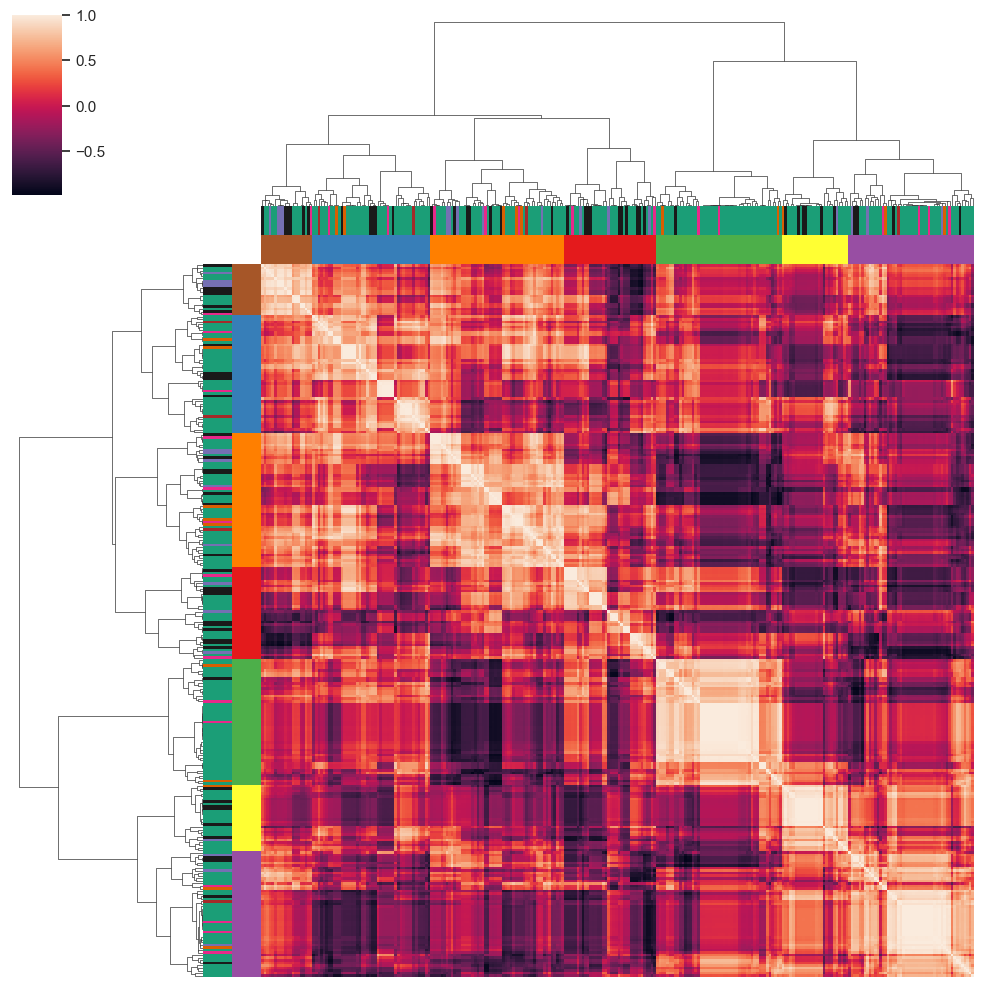

In [91]:
#####
# Plot
#####
sns.set(font_scale=1)
sns.clustermap(cosine_sim,
                   row_colors=[cluster_col,row_colors],
                   col_colors=[cluster_col,row_colors],
                   #xticklabels=cluster_name,
                   #yticklabels=cluster_name,
                    xticklabels=False,
                    yticklabels=False,
                   method=m
                  )

In [101]:
import phate
import scprep

In [105]:
phate_operator = phate.PHATE()
phate_scores = phate_operator.fit_transform(cosine_sim)

Calculating PHATE...
  Running PHATE on 278 observations and 278 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 4.06 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.23 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 4.60 seconds.


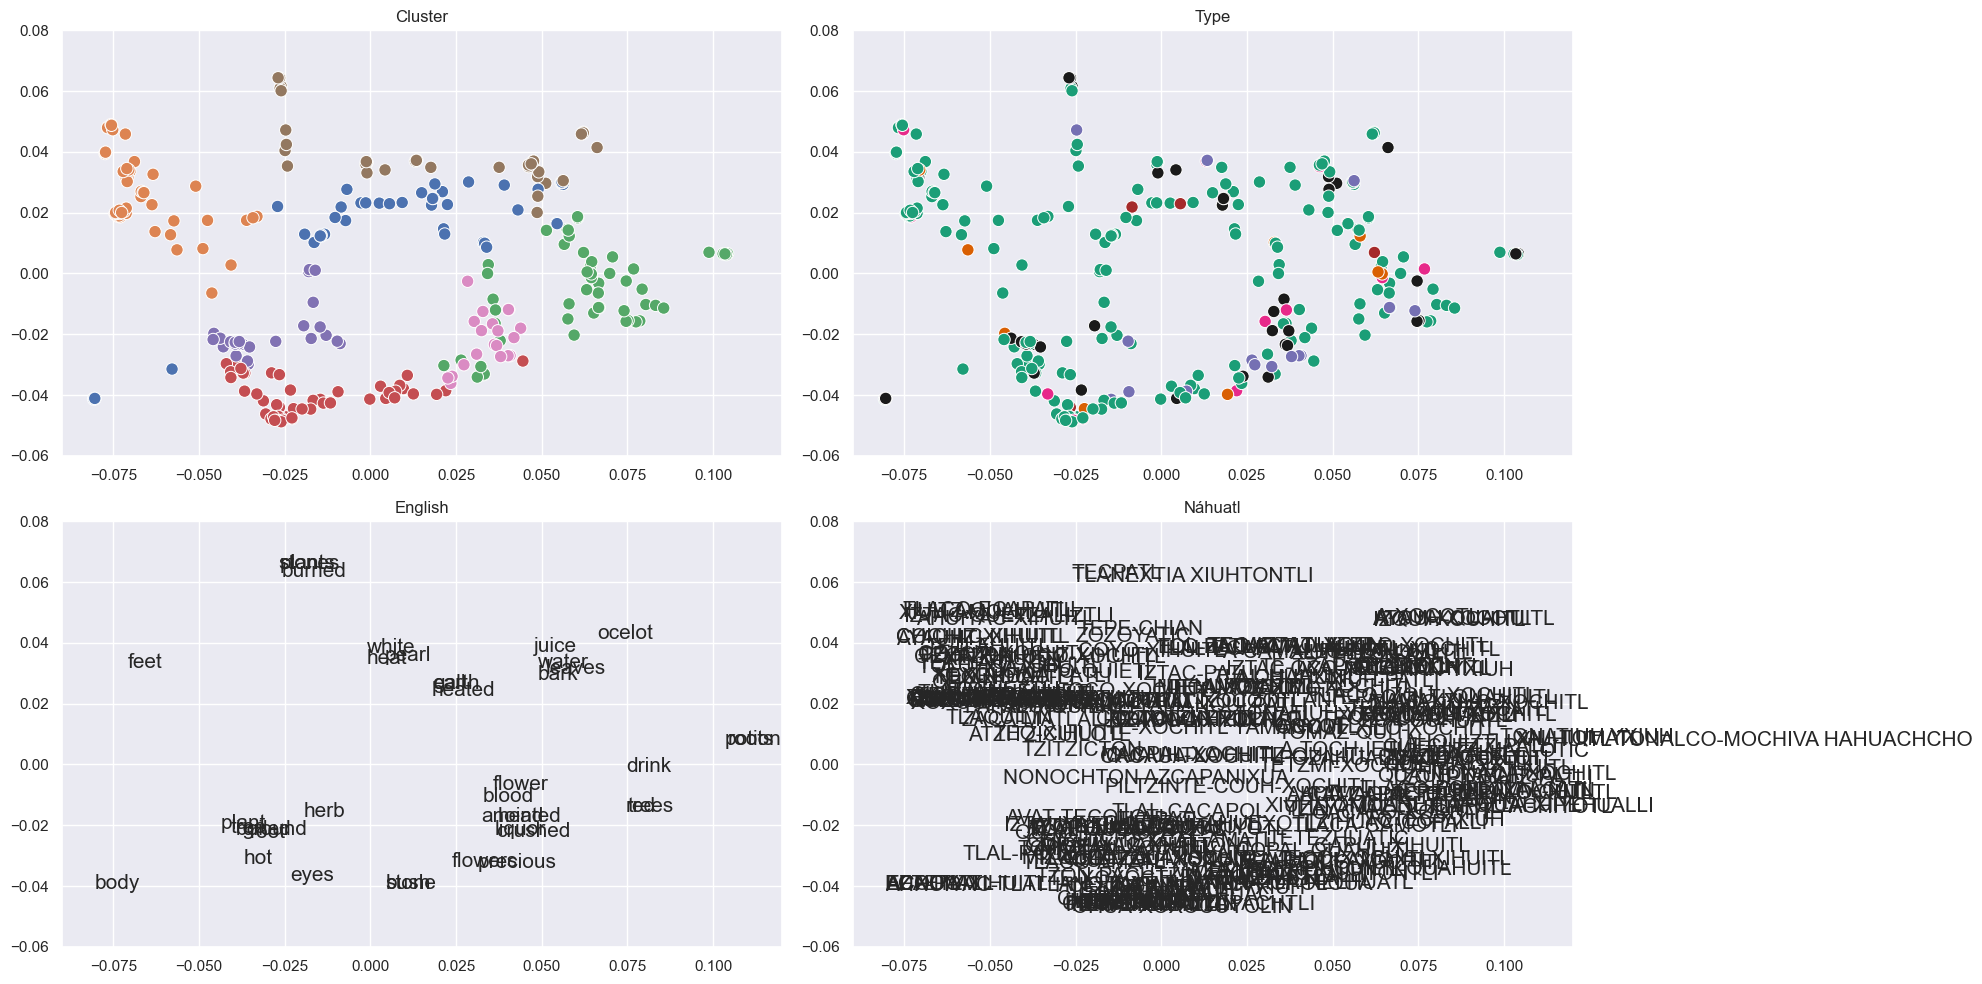

In [151]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.scatterplot(x=phate_scores[:,0], y=phate_scores[:,1], hue=row_colors, legend=False, s=80)
plt.title("Cluster")
plt.xlim(-0.09,0.12)
plt.ylim(-0.06,0.08)

plt.subplot(2,2,2)
pal_type = {'#1b9e77':'#1b9e77', '#7570b3':'#7570b3', '#d95f02':'#d95f02', '#e7298a':'#e7298a', 'brown':'brown', 'k':'k'}
sns.scatterplot(x=phate_scores[:,0], y=phate_scores[:,1], hue=cluster_col, legend=False, palette=pal_type, s=80)
plt.title("Type")
plt.xlim(-0.09,0.12)
plt.ylim(-0.06,0.08)

plt.subplot(2,2,3)
for i in range(len(cluster_type)):
    if cluster_type[i]=="word":
        plt.text(phate_scores[i,0],phate_scores[i,1],cluster_name[i], fontsize=15)
plt.title("English")
plt.xlim(-0.09,0.12)
plt.ylim(-0.06,0.08)

plt.subplot(2,2,4)
for i in range(len(cluster_type)):
    if (cluster_type[i]=="plant") | (cluster_type[i]=="animal") | (cluster_type[i]=="stone"):
        plt.text(phate_scores[i,0],phate_scores[i,1],cluster_name[i], fontsize=15)
plt.title("Náhuatl")
plt.xlim(-0.09,0.12)
plt.ylim(-0.06,0.08)

plt.tight_layout()

### Create a graph based on co-incidence

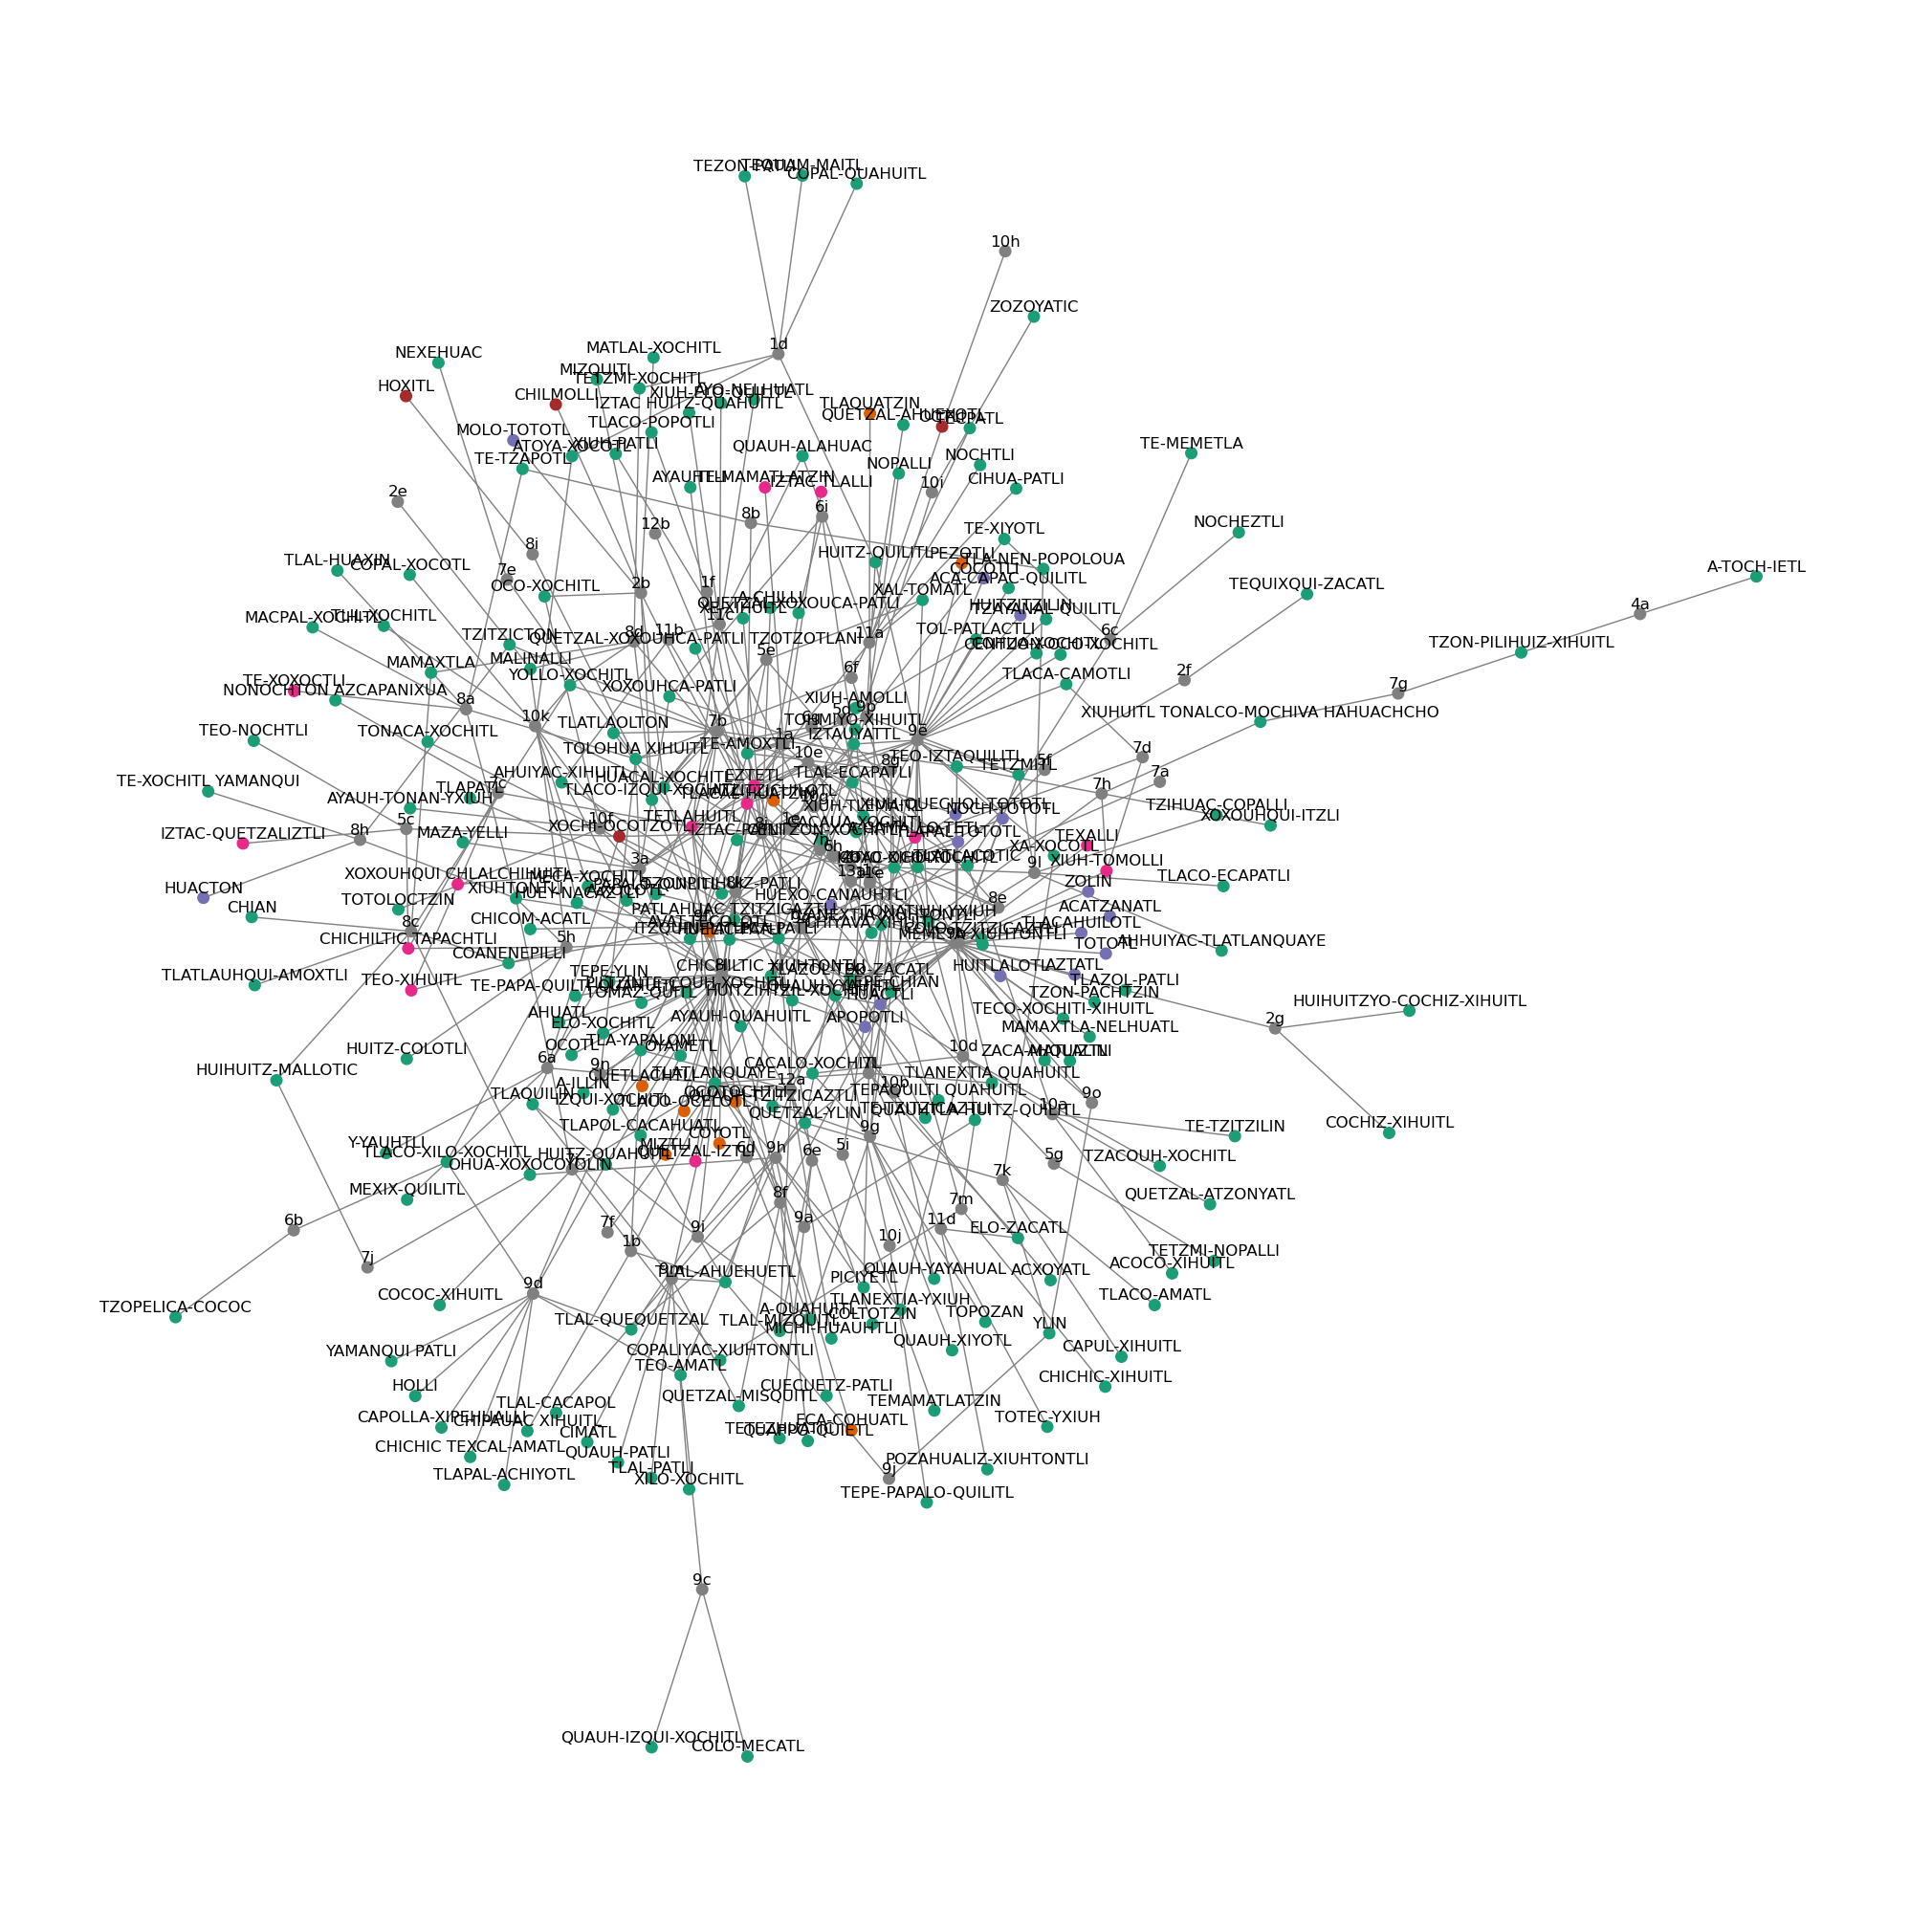

In [17]:
G=nx.Graph() # initialize graph
nodes = np.concatenate((present_df["chapter"].unique(), present_df["official"].unique())) # create nodes
G.add_nodes_from(nodes) # add nodes to graph

color_map = [] # create color scheme for nodes
for i in range(len(nodes)):
    curr_node = nodes[i]
    if any(char.isnumeric() for char in curr_node):
        color_map.append("gray")
    else:
        curr_type = present_df["type"][present_df["official"]==curr_node].iloc[0]
        if curr_type == "plant":
            color_map.append("#1b9e77") # green
        elif curr_type == "animal":
            color_map.append("#d95f02") # orange
        elif curr_type == "bird":
            color_map.append("#7570b3") # purple
        elif curr_type == "stone":
            color_map.append("#e7298a") # magenta
        elif curr_type == "other": 
            color_map.append("brown") # brown

unique_rows = present_df.drop_duplicates().reset_index() # create edges
edges = []
for i in range(len(unique_rows)):
    curr_row = unique_rows.iloc[i]
    curr_chapter = curr_row["chapter"]
    curr_object = curr_row["official"]
    edges.append((curr_chapter, curr_object))

G.add_edges_from(edges) # add edges to graph

#######################
# Choose graph layout #
#######################

pos = nx.kamada_kawai_layout(G, scale=2)
#pos = nx.spring_layout(G, k=0.15)

##############
# Plot graph #
##############

plt.figure(figsize=(20,20))

ns = 70 # node size
fs = 12 # font size
fc = "black" # font color
wl = False # with labels
ec = "gray" # edge color

nx.draw(G, pos, node_color=color_map, 
        with_labels=wl, 
        font_color=fc,
        node_size=ns,
        font_size=fs,
        edge_color=ec
       )

label_pos = {node: (x, y + 0.015) for node, (x, y) in pos.items()}  # Shift labels upward
nx.draw_networkx_labels(G, label_pos, font_size=12)

plt.show()